In [1]:
from init import *
from scipy.io import loadmat

autotime loaded.


In [2]:
def read_data(years, vortex=False, cols = ['Theta', 'Ozone', 'EqL'], freq = 'Q-NOV'):
    dates = []
    dfa = pd.DataFrame([])
    for year in years:
        files = sorted(glob.glob('../data/myth/%s/*.tmr'%year))
        for filename in files:
            dates.append(filename.split('/')[-1].split('_')[1])
            df = pd.read_csv(filename, sep='\s+', skiprows=1).iloc[:, [0, 6, 9]]
            df.columns = cols
            df = df.set_index('Theta')
            if vortex:
                df = df[df.EqL <= -65]
            dfa = pd.concat([dfa, df['Ozone']], axis=1)
    dfa.columns = pd.to_datetime(dates, yearfirst=True)
    dfa = dfa.iloc[2:25, :]
    dfa = dfa.to_xarray().to_array(dim='time', name='Ozone').rename({'index':'theta'}).T
    dfa = dfa.resample(time=freq).mean(dim='time')
    return dfa

def plot_data(dfa, levels=np.arange(0, 10, 0.25)):
    dt, pt = np.meshgrid(dfa.time, dfa.theta)
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    im = ax.contourf(dt, pt, dfa, levels=levels)
    cb = fig.colorbar(im, pad=0.015)
    cb.ax.set_ylabel('Ozone [ppmv]')
    ax.minorticks_on()
    ax.set_xlabel('Year')
    ax.set_ylabel('Theta [K]')
    return fig, ax, cb

time: 5.12 ms


In [3]:
freq = 'M'
levels = np.arange(0, 10, 0.25)
years = [1994, 1995, 1996, 1997, 1998, 2005, 2006, 2007, 2008]

df1 = read_data(years, vortex=False, freq=freq)
df2 = read_data(years, vortex=True, freq=freq)
df3 = df1.where(df1.time.dt.year < 2000).mean(dim='time').to_pandas()
df4 = df1.where(df1.time.dt.year >= 2000).mean(dim='time').to_pandas()

df5 = df2.where(df2.time.dt.year < 2000).mean(dim='time').to_pandas()
df6 = df2.where(df2.time.dt.year >= 2000).mean(dim='time').to_pandas()

time: 5.21 s


In [4]:
mat = loadmat('../data/myth/sond_avgPRF_31K_CF_noDDLAMIMY_CF.mat')
mat['stns']#['dat_davg'][..., -1].shape

array(['davs', 'fost', 'marb', 'mcmu', 'neum', 'spol', 'syow'],
      dtype='<U4')

time: 102 ms


In [5]:
asc = pd.read_csv('../data/myth/sond_avgPRF_31K_ba450_pt_vtxEqLna_noDDLA_CF_7914.asc', sep='\s+').set_index('YEAR')
new = pd.DataFrame([])
new['Before'] = asc.loc[:2000].mean(axis=0)#.to_frame()
new['After'] = asc.loc[2000:].mean(axis=0)#.to_frame()

time: 12.2 ms


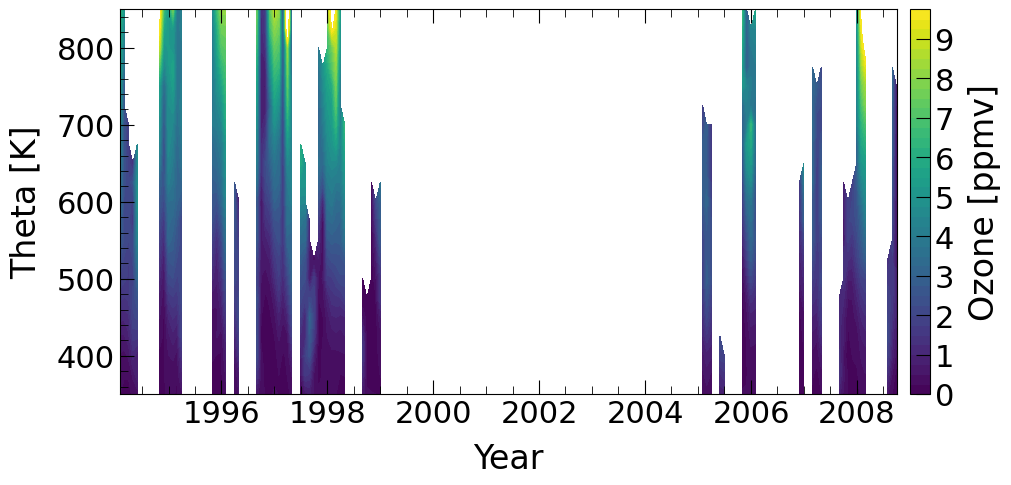

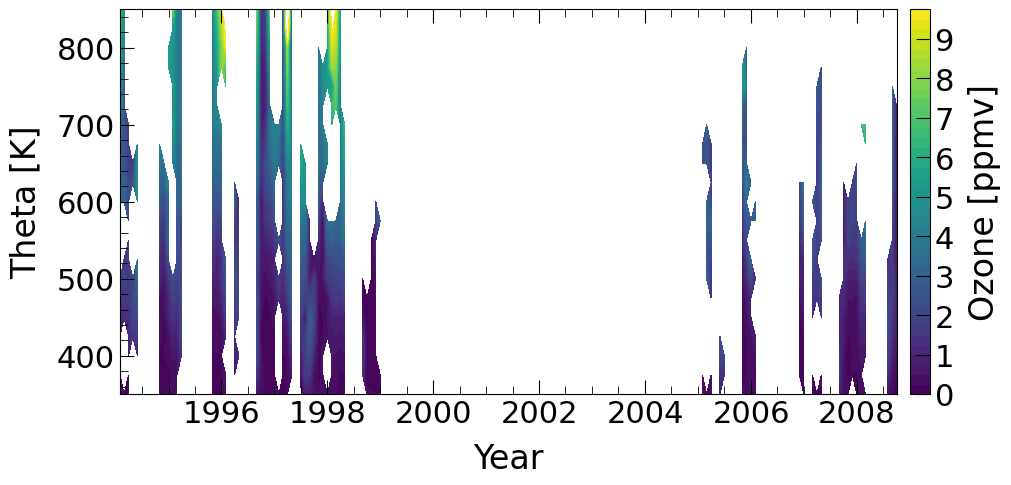

time: 1.91 s


In [6]:
for df, name in zip([df1, df2], ['All', 'Vortex']):
    fig, ax, cb = plot_data(df, levels)
    ax.set_ylim([350, 850])
    plt.savefig('./figs/%s.contourf.png'%name, bbox_inches='tight')
    plt.show()

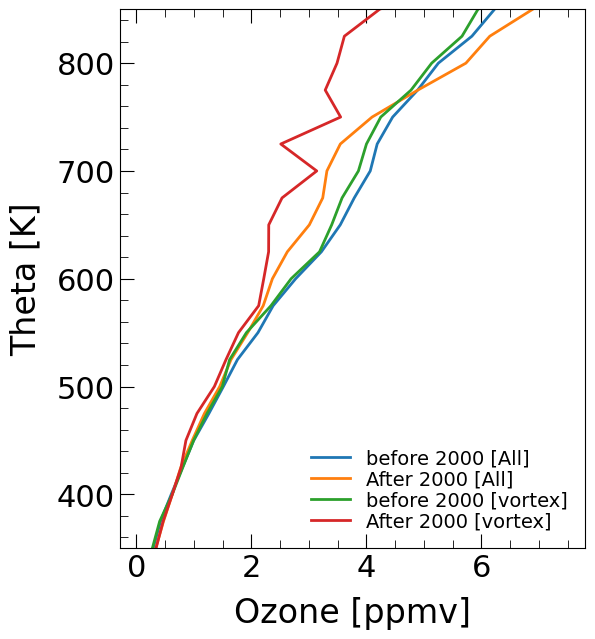

time: 608 ms


In [7]:
fig, ax = plt.subplots(figsize=(6, 7))
ax.plot(df3, df3.index, label='before 2000 [All]')
ax.plot(df4, df4.index, label='After 2000 [All]')
ax.plot(df5, df5.index, label='before 2000 [vortex]')
ax.plot(df6, df6.index, label='After 2000 [vortex]')
ax.minorticks_on()
ax.legend(loc=4, frameon=False, prop={'size':14})
ax.set_xlabel('Ozone [ppmv]')
ax.set_ylabel('Theta [K]')
ax.set_ylim([350, 850])
plt.savefig('./figs/eql.criteria.png', bbox_inches='tight')
plt.show()

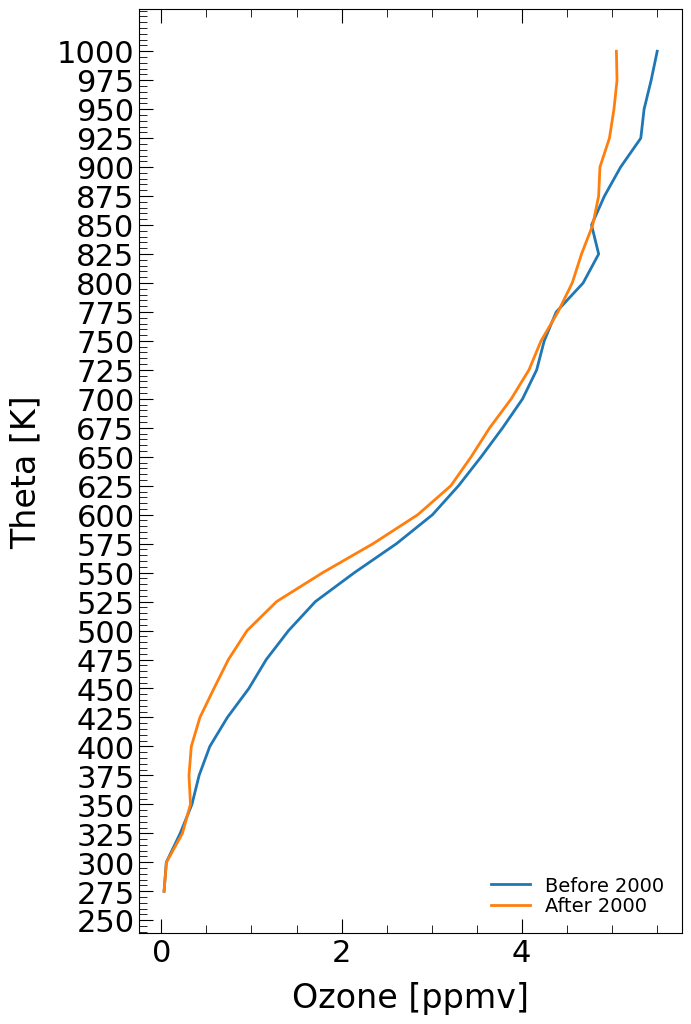

time: 1.12 s


In [8]:
fig, ax = plt.subplots(figsize=(7, 12))
for col, label in zip(new.columns, ['Before 2000', 'After 2000']):
    ax.plot(new[col], new.index, label=label)
ax.minorticks_on()
ax.legend(loc=4, frameon=False, prop={'size':14})
#ax.set_ylim([300, 900])
ax.set_xlabel('Ozone [ppmv]')
ax.set_ylabel('Theta [K]')
plt.savefig('./figs/sond_avg.png', bbox_inches='tight')
plt.show()

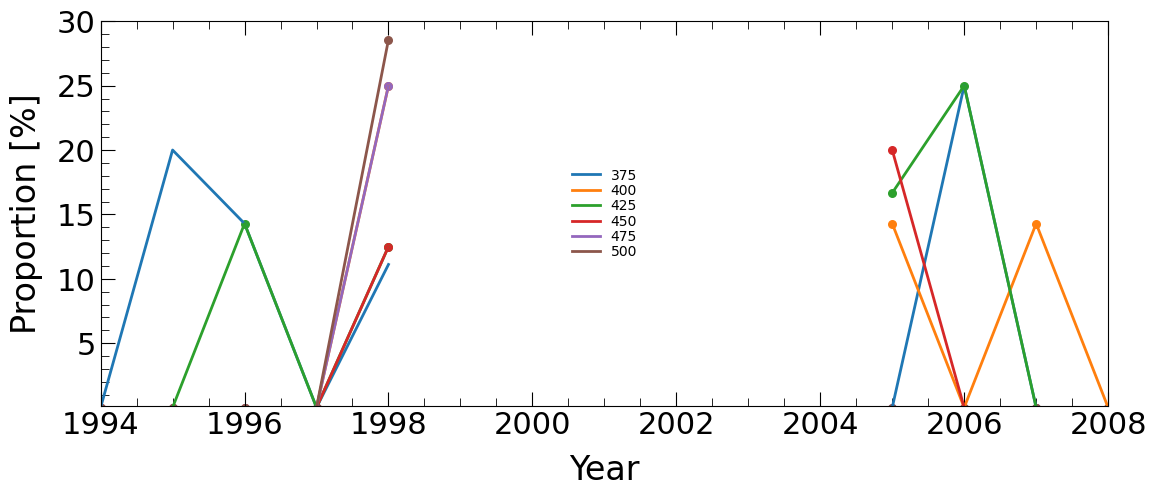

time: 1.15 s


In [9]:
sat = (df2 <= 0.1).resample(time='A').sum(dim='time')
# sat = sat.where(sat==0, np.nan)
tot = df2.resample(time='A').count(dim='time')
frac = 100 * (sat / tot).T.to_pandas().astype('float')
# frac[frac==0] = np.nan

fig, ax = plt.subplots(figsize=(13, 5))
for col in np.arange(375, 501, 25):
    tmp = frac[col]#[frac[col]!=0]
    ax.scatter(tmp.index, tmp, 30)
    tmp.plot(ax=ax, label=col)
ax.legend(frameon=False, loc=10)   
ax.minorticks_on()
ax.set_ylim([0.1, 30])
ax.set_xlabel('Year')
ax.set_ylabel('Proportion [%]')
plt.savefig('./figs/myth.saturtion.png', bbox_inches='tight')
plt.show()

In [93]:
def partial_column(df, du = 2.69E16*1E-12*1E-5, levs=[400, 550]):
    loss = df.sel(theta=slice(levs[0], levs[1]))
    delp = np.diff(loss.theta)[0]
    loss = loss.rolling(theta=2).mean().sum('theta')
    loss[loss==0] = np.nan
    loss  = (du * loss * delp)
    return loss

df2['theta'] = df2.theta.astype('float')
poc = partial_column(df2, du = 2.69E16*1E-12*1E-5, levs=[400, 550]).to_pandas().resample('M').mean()
tom = pd.read_csv('../data/ee.toms.toc.csv', parse_dates=['Date']).set_index('Date').resample('M').mean()
tom = tom[tom.index.month==10]
poc = poc[poc.index.month==10]
# tom

time: 44 ms


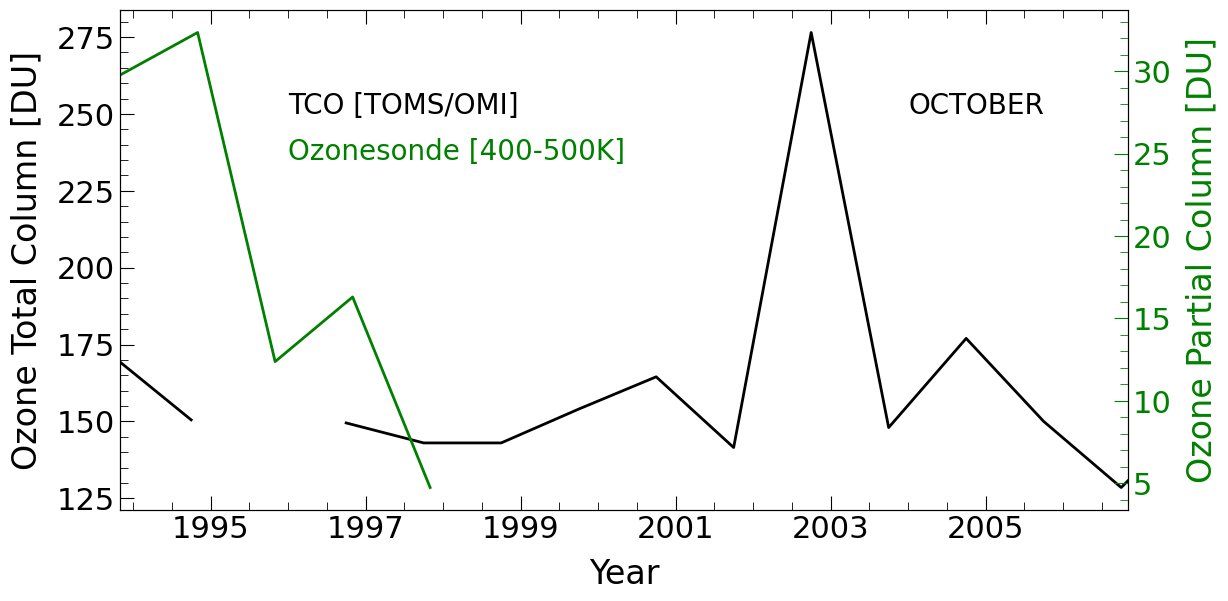

time: 1.01 s


In [114]:
fig, ax = plt.subplots(figsize=(13, 6.5))
ax1 = ax.twinx()
tom.plot(ax=ax, color='k', label='TOTAL COLUMN [TOMS/OMI]', legend=False)
poc.plot(ax=ax1, color='g', label='OZONESONDE PARTIAL COLUMN [400-500K]')
ax.minorticks_on()
ax1.minorticks_on()
ax.set_xlabel('Year')
ax.set_ylabel('Ozone Total Column [DU]')
ax1.set_ylabel('Ozone Partial Column [DU]')
ax1.yaxis.label.set_color('g')
ax1.tick_params(axis='y', which='both', color='g', labelcolor='g')

ax.text('01-10-2004', 250, 'OCTOBER', )
for i, (txt, color) in enumerate(zip(['TCO [TOMS/OMI]', 'Ozonesonde [400-500K]'], ['k', 'g'])):
    ax.text('01-10-1996', 250- i*15, txt, color=color)
plt.savefig('./figs/myth.fig5.png', bbox_inches='tight')
plt.show()